# Проведение A/B тестирования на основе данных сервиса 'Яндекс Книги' и  данных  интернет-магазина BitMotion Kit

# Часть 1. Проверка гипотезы в Python и составление аналитической записки

- Автор: Тюлюпов Глеб
- Дата: 30.06.2025

## Цели и задачи проекта

**Цель:** Проведение A/B тестирования на основе данных сервиса 'Яндекс Книги' с целью проверки гипотезы и сравнения времени за чтением и прослушиванием книг для пользователей из Санкт-Петербурга и из Москвы.   

**Задачи:**
1. Знакомство с данными: загрузка и первичная предобработка, в том числе:
     - загрузка необходимых библиотек;
     - вывод общей информации и общее знакомство с данными.
     
     
2. Проверка и предобработка данных, подготовка к тесту в том числе:
     - проверка данных на пропуски и дубликаты;
     - проверка данных на аномалии и выбросы;
     - проверка выборок на пересечение.
     
     
3. Проверка гипотезы в Python, в том числе:
    - выгрузка основных статистик для обеих выборок;
    - выбор типа статистического теста;
    - проведение A/B тестирования.
    
    
4. Составление аналитической записки, формулирование выводов и рекомендаций по проведённому анализу.

## Содержимое проекта

 Проект включает в себя следующие основные этапы:
   1. Знакомство с данными: загрузка и первичная предобработка.
   2. Проверка и предобработка данных, подготовка к тесту.
   3. Проверка гипотезы в Python.
   4. Составление аналитической записки, формулирование выводов и рекомендаций по проведённому анализу.


## 1. Загрузка данных и знакомство с ними

На самом первом шаге импортируем все необходимые биоблиотеки и функции.

In [1]:
# Импортируем биоблиотеку pandas
import pandas as pd

# Импортируем библиотеку matplotlib.pyplot для визуализации данных
import matplotlib.pyplot as plt

# Импортируем библиотеку numpy для математических расчётов
import numpy as np

# Импортируем функцию ttest_ind из модуля scipy.stats
from scipy.stats import ttest_ind

# Импортируем из модуля sstatsmodels.stats.proportion функцию proportion_effectsize
from statsmodels.stats.proportion import proportion_effectsize

# Импортируем из модуля statsmodels.stats.power функцию NormalIndPower
from statsmodels.stats.power import NormalIndPower

# Импортируем из модуля statsmodels.stats.proportion функцию proportions_ztest
from statsmodels.stats.proportion import proportions_ztest

Далее создадим датафрейм с данными пользователей из Москвы и Санкт-Петербурга c их активностью, загрузив файл /datasets/yandex_knigi_data.csv, а также выведем несколько строк полученного датафрейма.

In [2]:
# Создам датафрейм knigi_df, содержащий информацию CSV-файла yandex_knigi_data.csv
knigi_df=pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv')

knigi_df

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434
...,...,...,...,...
8779,8779,Санкт-Петербург,1130000028554332,4.107774
8780,8780,Санкт-Петербург,1130000030307246,45.069222
8781,8781,Санкт-Петербург,1130000038726322,0.211944
8782,8782,Санкт-Петербург,1130000047892100,4.311841


Выведем общую информарцию о датафрйеме методом info()

In [3]:
 # Выведем общую информацию о датафрйеме методом info()
knigi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


Как видно из выгрузки датафрем содержит 4 столбца и 8784 строк. При этом столбец `Unnamed: 0` по всей видимости содержит номер индекса записи датафрейма.

Пропуски в датафрейме отсутствуют.

Столбцы `Unnamed: 0` и `puid`  содержат информацию в формате `int64`, что  являются для данных столбцов оптимальным форматом, однако, для `столбца Unnamed: 0` можно оптимизировать разрядность с помощью метода `to_numeric`.

Столбец `city` содержит данные в формате `object`, что полностью соответствует отражаемой в нём информации о городе соответствующего пользователя.

Столбец `hours` содержит информацию в формате `float64`, что также является оптимальным форматом.

### Промежуточный вывод

Таким образом, в данном разделе была проведена загрузка необходимых библиотек и функций для дальнейшей работы.

Были загружены необходимые данные из файла `yandex_knigi_data.csv` в датафрейм `knigi_df`. Также было проведено первичное знакомство с данными, в ходе которого было установлено:

     - названия столбцов корректно отражают содержащуюся в них информацию;
     - в датафрейме отсутствуют пропуски;
     - данные в каждом столбце содержатся в оптимальных форматах.   

## 2. Проверка гипотезы в Python

Перед проведением статистического теста проведём предварительную проверку корректности данных. Для этого проверим данные на пропуски, дубликаты, пересечение. 

Сначала проверим данные на дубликаты.

In [4]:
# Проверяем полные дубликаты в датафрейме rest_df
knigi_df.duplicated().sum()

0

Явных дубликатов в датафрейме не обнаружено.

Далее проверим данные на аномалии и выбросы.

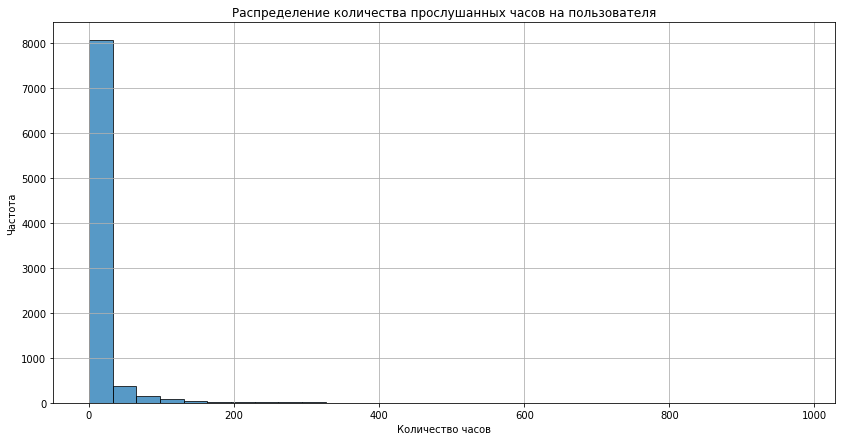

In [5]:
plt.figure(figsize=(14, 7))

# Строим гистограмму с помощью pandas через plot(kind='hist')
knigi_df['hours'].plot(
                kind='hist', 
                bins=30, 
                alpha=0.75,
                edgecolor='black',
)

# Настраиваем оформление графика
plt.title('Распределение количества прослушанных часов на пользователя')
plt.xlabel('Количество часов')
plt.ylabel('Частота')

# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show() 

Из графика видно, что явные выбросы и аномалии отсутствуют.

На следующем этапе проверим группы на пересечение.

In [6]:
# Выведем id пользователей для обеих групп
Group_SPB = knigi_df[knigi_df['city'] == 'Санкт-Петербург']['puid']
Group_MSC = knigi_df[knigi_df['city'] == 'Москва']['puid']

# Проведём проверку групп на пересечение
intersection = list(set(Group_SPB) & set(Group_MSC))
print(intersection) 

[439054848, 98068993, 84978689, 331188228, 59679749, 790564870, 40698887, 162106378, 1078819852, 1684058125, 1130000018954257, 959563282, 571554323, 1358054932, 313990163, 1778617878, 1210363415, 1316543509, 649885721, 1183963675, 1395494429, 1314529823, 1145886241, 1593760291, 1725564965, 24138278, 520518182, 363351088, 108083761, 570189363, 584447544, 860187201, 309104707, 550835780, 441112643, 1977784899, 1406501962, 528250442, 103543372, 1616171597, 589188176, 989693522, 1958805587, 401065555, 1557916755, 429727314, 1130000028554332, 488154206, 1965288031, 10597984, 9979490, 301108324, 1607495785, 767485035, 453988975, 912829040, 955554416, 1672056947, 819309176, 10815097, 196683896, 1076879993, 1974615673, 531369086, 1011254911, 555866239, 258809476, 66998918, 360290950, 1085783174, 236601993, 359740041, 998045836, 888840333, 2019864206, 1109631631, 1713008273, 317826707, 1236880533, 46837910, 1166679702, 137198745, 1891219106, 987817124, 1735154341, 176447657, 1748029097, 3793466

Как видно, обнаружено значительное количество пересечений, то есть пользователей, оказавшихся в обеих группах.

Выведем количество пересечений.

In [7]:
# Выведем количество пересечений
len(intersection)

244

Всего обнаружено 244 пересечения.

Чтобы не возникло искажений результатов при проведении тестирования, удалим данных пользователей и для проверки выведем размер обновлённого датафрейма.

In [8]:
# Удаляем из датафрейма пользователей, оказавшихся в обеих группах
knigi_df = knigi_df[~knigi_df['puid'].isin(intersection)]

# Выведем размер обновлённого датафрейма для проверки корректности удаления пересечений
len(knigi_df)

8296

Далее выведем статистики для обеих групп методом `describe()`.

In [9]:
# Выведем статистики для пользователей из Санкт-Петербурга
display(knigi_df[knigi_df['city'] == 'Санкт-Петербург']['hours'].describe())

# Выведем статистики для пользователей из Москвы
knigi_df[knigi_df['city'] == 'Москва']['hours'].describe()

count    2306.000000
mean       11.264433
std        39.831755
min         0.000025
25%         0.060173
50%         0.875355
75%         6.138424
max       978.764775
Name: hours, dtype: float64

count    5990.000000
mean       10.848192
std        36.925622
min         0.000022
25%         0.057042
50%         0.888232
75%         5.933439
max       857.209373
Name: hours, dtype: float64

Из выгрузки видно, что количество пользователей из Москвы значительно выше численности пользователей из Санкт-Петербурга. Остальные статистики для обеих групп имеют схожие значения.

Далее отдельно выведем средние значения активности пользователей для обеих групп. 

In [10]:
# Выведем среднее количество часов активности для пользователей обоих городов
knigi_df.groupby('city',as_index = False)['hours'].mean()

,city,hours
0,Москва,10.848192
1,Санкт-Петербург,11.264433


Выведем абсолютную и относительную разницу в средних значения для обеих групп.

In [11]:
# Выведем разницу между средними значениями активности в абсолютном значении
print('Абсолютная разница в доле успешных сессий между группами:')
print(knigi_df[knigi_df['city'] == 'Санкт-Петербург']['hours'].mean()-knigi_df[knigi_df['city'] == 'Москва']['hours'].mean())

# Выведем разницу между средними значениями активности в относительном значении
print('Относительная разница в доле успешных сессий между группами:')
print((knigi_df[knigi_df['city'] == 'Санкт-Петербург']['hours'].mean()-knigi_df[knigi_df['city'] == 'Москва']['hours'].mean())/knigi_df[knigi_df['city'] == 'Санкт-Петербург']['hours'].mean()*100)

Абсолютная разница в доле успешных сессий между группами:
0.416241859890361
Относительная разница в доле успешных сессий между группами:
3.695186844539218


Таким образом, среднее время активности для пользователей из Санкт-Петербурга больше на 3,7%, чем время среднее время активности пользователей из Москвы.

Далее с помощью A/B тестирования рассмотрим, является ли данная разница статистически значимой. 

Так как объём выборки для пользователей из Санкт-Петербурга значительна ниже выборки для пользователей из Москвы, в качестве статистического теста используем t-тест Уэлча.

In [12]:
metric_a = knigi_df[knigi_df.city == 'Санкт-Петербург']['hours'] ## выборка целевой метрики для группы A
metric_b = knigi_df[knigi_df.city == 'Москва']['hours']  ## выборка целевой метрики для группы B

alpha = 0.05 

stat_welch_ttest, p_value_welch_ttest = ttest_ind(
    metric_a, 
    metric_b, 
    equal_var=False,
    alternative='greater')

if p_value_welch_ttest>alpha:
    print(f'p-value теста Уэлча ={round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'p-value теста Уэлча ={round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза не находит подтверждения!')
    

p-value теста Уэлча =0.33
Нулевая гипотеза находит подтверждение!


Таким образом, полученное значение p-value теста Уэлча превосходит уровень значимости alpha, что означает, что нет оснований отвергать нулевую гипотезу и среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

### Промежуточный вывод

В данном разделе была проведена проверка и предобработка данных. В том числе была проведена проверка данных на дубликаты, в ходе которой было установлено, что явных дубликатов не выявлено. Далее были рассмотрены аномалии и выбросы в данных. Существенных выбросов зафиксировано не было. После чего была осуществлена проверка выборок на пересечение, в ходе которой было установлены 244 пересекающиеся записи. Данные записи были удалены, чтобы избежать искажения дальнейших результатов при проведении статистического теста.

На следующем этапе были рассмотрены основные статистики для обеих групп пользователей. Было установлено, что количество пользователей из Москвы значительно выше численности пользователей из Санкт-Петербурга. Остальные статистики для обеих групп имеют схожие значения. При этом среднее время активности для пользователей из Санкт-Петербурга оказалось на 3,7%, чем  среднее время активности пользователей из Москвы.

Для оценки статистической значимости разницы между выборками был проведён t-тест Уэлча, в ходе которого было установлено, что среднее время активности пользователей Санкт-Петербурга не превышает время активности пользователей из Москвы.

## 3. Аналитическая записка

Для проверки статистической значимости разницы между средними значениями активности пользователей был использован T-тест Уэлча, так как размеры выборок для обеих групп существенно отличаются. Уровень значимости был установлен на уровне alpha = 0.05.

По итогам проведённого теста уровень p-value теста Уэлча составил 0.33, что ниже установленного уровня значимости alpha = 0.05. В результате чего, можно сделать вывод, что нет оснований отвергать нулевую гипотезу о том, что среднее значение активности для пользователей из Санкт-Петербурга не превышает среднее время активности пользователей из Москвы. То есть пользователи из Санкт-Петербурга не проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы.

Отсутствие статистической значимости разницы между двумя выборками, несмотря на фактическую разницу средних значений, может объясняться малой мощностью теста, недостаточно большим размером выборок для обнаружения существующей разницы. В связи с чем для дополнительной проверки имеет смысл рассмотреть увеличение количества наблюдений.

----

# Часть 2. Проведение A/B тестирования на основе данных  интернет-магазина BitMotion Kit

## 1. Цели исследования

**Цель:** Проведение A/B тестирования на основе данных  интернет-магазина BitMotion Kit, с целью проверки гипотезы и сравнения конверсии зарегистрированных пользователей в покупатели между пользователями, которыми был показан старый и новый интерфейсы.    

**Задачи:**
1. Знакомство с данными: вывод общей информации и общее знакомство с данными
     
2. Оценка корректности проведения теста, в том числе:
     - проверка данных на равномерность распределения на группы;
     - проверка данных на пересечение между группами;
     - проверка данных на дубликаты;
     - проверка данных на распределение по устройствам регистрации между группами;
     - проверка выборок на пересечение с параллельным тестом.
     
     
3. Анализ данных о пользовательской активности, в том числе:
    - фильтрация событий, связанных с участвующими в изучаемом тесте пользователями;
    - определите горизонта анализа: расчёт времени совершения события пользователем после регистрации;
    - расчёт для каждой группы количество посетителей, сделавших покупку, и общего количество посетителей;
    - предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.
    
    
4. Оценка результатов A/B-тестирования, в том числе:
    - предварительная оценка выборок на достаточность для проведения теста;
    - непосредственно проведение статистического теста;
    - интерпретация полученных результатов.

## 2. Загрузка и оценка данных


In [13]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

В начале рассмотрим датафрейм participants с участниками тестов.

In [14]:
# Выведем датафрейм participants
display(participants)

# Выведем информацию о датафрейме participants методом info()
participants.info()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac
...,...,...,...,...
14520,FFE7FC140521F5F6,A,interface_eu_test,PC
14521,FFEFC0E55C1CCD4F,A,interface_eu_test,PC
14522,FFF28D02B1EACBE1,B,recommender_system_test,PC
14523,FFF28D02B1EACBE1,B,interface_eu_test,PC


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


Всего датафрейм содержит 4 столбца и 14525 записей. Пропуски отсутствуют. Все столбцы содержат информацию в формате object, что оптимально отражает содержащуюся в них информацию.

Далее выведем, какие тесты отображены по столбцу `ab_test`.

In [15]:
# Выведем имеющиеся значения по столбцу ab_test
participants['ab_test'].value_counts()

interface_eu_test          10850
recommender_system_test     3675
Name: ab_test, dtype: int64

Всего в датафрейме содержится информация о двух проводимых тестах, участников которых в дальнейшем необходимо будет проверить на пересечение.

Далее выведем информацию о датафрейме `events`.

In [16]:
# Выведем датафрейм events
display(events)

# Выведем информацию о датафрейме events методом info()
events.info()

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN
...,...,...,...,...
787281,1A655C280B064708,2020-12-31 23:57:44,product_page,NaN
787282,B77B2F4BCA134618,2020-12-31 23:58:23,registration,0.0
787283,GLOBAL,2020-12-31 23:58:30,product_cart,NaN
787284,B12AD1623E494FAD,2020-12-31 23:58:34,registration,-6.52


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


Всего датафрейм содержит 4 столбца и 787 286 строк. Имеются пропуски по столбцу `details`, т.к. в данном столбце отражается информация только для событий (`event_name`) `registration` и `purchase`. Текущие форматы данных для каждого столбца явяются оптимальными.

Дополнительно выведем типы событий по столбцу `event_name`.

In [17]:
# выведем типы событий по столбцу event_name
events['event_name'].value_counts()

login                                 248285
product_page                          195606
registration                          144183
purchase                              104836
product_cart                           94373
End of Black Friday Ads Campaign           1
Start of CIS New Year Gift Lottery         1
Start of Christmas&New Year Promo          1
Name: event_name, dtype: int64

### Промежуточный вывод

В данном разделе были проведены загрузка данных и оценка их целостности. Текущие форматы данных для каждого столбца обоих датафреймов являются оптимальными. Пропуски содержатся только по столбцу `details` датафреймов `events`, т.к. в данном столбце отражается информация только для событий (`event_name`) `registration` и `purchase`.

## 3.1 По таблице `ab_test_participants` оценим корректность проведения теста

Нас интересует данные, относящиеся к тесту по упрощению интерфейса. Данный тест имеет название `interface_eu_test` по столбцу `ab_test`. Создадим отдельный датафрейм `participants_interface_test`, содержащий информацию непосредственно об интересующем нас тесте.

In [18]:
# Создадим датафрейм с данными о тесте interface_eu_test
participants_interface_test=participants[participants['ab_test']=='interface_eu_test']

# Выведем полученный датафрейм
participants_interface_test

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
2,001064FEAAB631A1,A,interface_eu_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac
5,002412F1EB3F6E38,B,interface_eu_test,Mac
6,002540BE89C930FB,B,interface_eu_test,Android
...,...,...,...,...
14519,FFE600EEC4BA7685,B,interface_eu_test,Android
14520,FFE7FC140521F5F6,A,interface_eu_test,PC
14521,FFEFC0E55C1CCD4F,A,interface_eu_test,PC
14523,FFF28D02B1EACBE1,B,interface_eu_test,PC


Далее проверим равномерность распределения пользователей по группам теста.

In [19]:
# Выведем количество пользователей для каждой группы 
display(participants_interface_test[participants_interface_test['group'] == 'A']['user_id'].nunique(), 
        participants_interface_test[participants_interface_test['group'] == 'B']['user_id'].nunique())

# Выведем процентное соотношение пользователей для каждой группы 
display(100 * participants_interface_test[participants_interface_test['group'] == 'A']['user_id'].nunique() / participants_interface_test['user_id'].nunique(), 
100 * participants_interface_test[participants_interface_test['group'] == 'B']['user_id'].nunique() / participants_interface_test['user_id'].nunique()) 

5383

5467

49.61290322580645

50.38709677419355

Таким образом, пользователи в группе А меньше, чем количество пользователей в группе B, при этом разница не является критичной.

Далее дополнительно проверим датафрейм `participants_interface_test` на дубликаты.

In [20]:
# Проверим датафрейм participants_interface_test на дубликаты
participants_interface_test.duplicated().sum()

0

Дубликаты отсутствуют.

Далее проверим выборки для пользователей, попавших в `interface_test` на пересечение.

In [21]:
# Проверим выборки на наличие пересечений
Group_A = participants_interface_test[participants_interface_test['group'] == 'A']['user_id']
Group_B = participants_interface_test[participants_interface_test['group'] == 'B']['user_id']

intersection = list(set(Group_A) & set(Group_B))
print(intersection) 

[]


Пересечения отсутсвтуют.

Далее проверим распределение между устройствами, с которых происходила регистрация, между группами. 

In [22]:
# Сгруппируем пользователей для обеих групп по устройствам регистрации
device_for_group_A = participants_interface_test[participants_interface_test['group'] == 'A'].groupby('device')['user_id'].nunique()
device_for_group_B = participants_interface_test[participants_interface_test['group'] == 'B'].groupby('device')['user_id'].nunique()

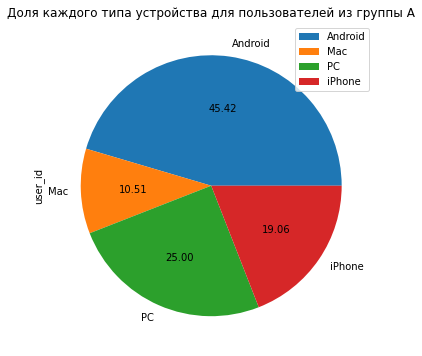

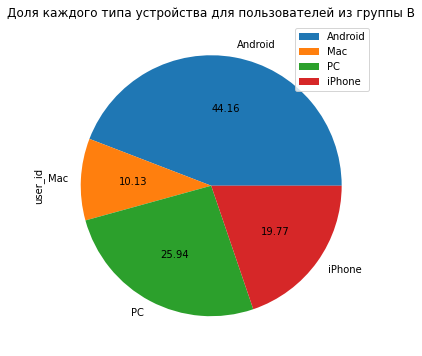

In [23]:
# Построим визуализацию для отображения разницы в доле каждого типа устройства для пользователей из группы A
plt.figure(figsize=(8, 6))

device_for_group_A.plot(
               kind='pie', 
               title=f'Доля каждого типа устройства для пользователей из группы A',
               autopct='%.2f')

plt.legend()
plt.show()

# Построим визуализацию для отображения разницы в доле каждого типа устройства для пользователей из группы B
plt.figure(figsize=(8, 6))

device_for_group_B.plot(
               kind='pie', 
               title=f'Доля каждого типа устройства для пользователей из группы B',
               autopct='%.2f')

plt.legend()
plt.show()

Как видно из диаграмм, значительная разница в распределении между устройствами в обеих группах отсутствует.

Далее проверим отсутствие пересечений с конкурирующим тестом `recommender_system_test`.

In [24]:
# Выведем id пользователей для обеих групп
users_interface_test=participants[participants['ab_test']=='interface_test']['user_id']
users_recommender_system_test=participants[participants['ab_test']=='recommender_system_test']['user_id']

# Проведём проверку групп на пересечение
intersection = list(set(users_interface_test) & set(users_recommender_system_test))
print(intersection) 

[]


Таким образом, пересечения отсутствуют.

## 3.2 Проанализируем данные о пользовательской активности по таблице `ab_test_events`

Поскольку нас интересует изменения конверсии зарегистрированных пользователей в покупателей, создадим новый датафрейм, включающий в себя только события, связанные с регистрацией и покупкой.

In [25]:
# Создадим датафрейм с регистрациями и покупками
ab_test_events = events[(events['event_name']=='purchase')|(events['event_name']=='registration')]

# Выведем поученный датафрейм
ab_test_events

,user_id,event_dt,event_name,details
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
5,AA346F4D22148024,2020-12-01 00:01:46,registration,-2.0
6,7EF01D0E72AF449D,2020-12-01 00:02:06,registration,-5.0
7,9A6276AD14B14252,2020-12-01 00:02:20,registration,-2.0
8,9B186A3B1A995D36,2020-12-01 00:02:37,registration,-3.5
...,...,...,...,...
787273,CA617333EFAE4A10,2020-12-31 23:56:25,registration,-2.85
787277,10CAFD77114A4537,2020-12-31 23:56:56,registration,-4.07
787282,B77B2F4BCA134618,2020-12-31 23:58:23,registration,0.0
787284,B12AD1623E494FAD,2020-12-31 23:58:34,registration,-6.52


Объединим полученный датафрейм с пользователями, участвующими в тесте, по полю `user_id`.

In [26]:
# Объединяем датафреймы с пользователями и событиями
interface_test=participants_interface_test.merge(ab_test_events, on='user_id', how='left')

# Выведем полученный датафрейм
interface_test

,user_id,group,ab_test,device,event_dt,event_name,details
0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:31,registration,-2.38
1,001064FEAAB631A1,A,interface_eu_test,Android,2020-12-20 14:12:45,registration,-2.14
2,001E72F50D1C48FA,A,interface_eu_test,Mac,2020-12-17 15:44:05,registration,-3.61
3,002412F1EB3F6E38,B,interface_eu_test,Mac,2020-12-09 09:36:50,registration,-0.48
4,002540BE89C930FB,B,interface_eu_test,Android,2020-12-08 18:06:07,registration,-2.38
...,...,...,...,...,...,...,...
21070,FFE7FC140521F5F6,A,interface_eu_test,PC,2020-12-26 14:37:21,purchase,4.49
21071,FFE7FC140521F5F6,A,interface_eu_test,PC,2020-12-26 14:37:51,purchase,4.49
21072,FFEFC0E55C1CCD4F,A,interface_eu_test,PC,2020-12-13 23:52:15,registration,0.0
21073,FFF28D02B1EACBE1,B,interface_eu_test,PC,2020-12-16 08:23:56,registration,-0.45


Для начала создадим датафрейм, в котором для каждого пользователя будет указана дата регистрации

In [27]:
# Создадим датафрейм с датай регистриации пользователей
registration_date= interface_test[interface_test['event_name']=='registration'][['user_id','event_dt']]

# Выведем полученный датафрейм
registration_date

,user_id,event_dt
0,0002CE61FF2C4011,2020-12-07 04:37:31
1,001064FEAAB631A1,2020-12-20 14:12:45
2,001E72F50D1C48FA,2020-12-17 15:44:05
3,002412F1EB3F6E38,2020-12-09 09:36:50
4,002540BE89C930FB,2020-12-08 18:06:07
...,...,...
21068,FFE600EEC4BA7685,2020-12-13 21:43:31
21069,FFE7FC140521F5F6,2020-12-23 09:10:16
21072,FFEFC0E55C1CCD4F,2020-12-13 23:52:15
21073,FFF28D02B1EACBE1,2020-12-16 08:23:56


Далее присоединим полученный датафрейм с датой регистрацией пользователей с основному датафрейму.

In [28]:
# При присоединим полученный датафрейм с датой регистрацией пользователей с основному датафрейму
interface_test = interface_test.merge(registration_date, on='user_id', how='left')

# Выведем обновлённый датафрейм
interface_test

,user_id,group,ab_test,device,event_dt_x,event_name,details,event_dt_y
0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:31,registration,-2.38,2020-12-07 04:37:31
1,001064FEAAB631A1,A,interface_eu_test,Android,2020-12-20 14:12:45,registration,-2.14,2020-12-20 14:12:45
2,001E72F50D1C48FA,A,interface_eu_test,Mac,2020-12-17 15:44:05,registration,-3.61,2020-12-17 15:44:05
3,002412F1EB3F6E38,B,interface_eu_test,Mac,2020-12-09 09:36:50,registration,-0.48,2020-12-09 09:36:50
4,002540BE89C930FB,B,interface_eu_test,Android,2020-12-08 18:06:07,registration,-2.38,2020-12-08 18:06:07
...,...,...,...,...,...,...,...,...
21070,FFE7FC140521F5F6,A,interface_eu_test,PC,2020-12-26 14:37:21,purchase,4.49,2020-12-23 09:10:16
21071,FFE7FC140521F5F6,A,interface_eu_test,PC,2020-12-26 14:37:51,purchase,4.49,2020-12-23 09:10:16
21072,FFEFC0E55C1CCD4F,A,interface_eu_test,PC,2020-12-13 23:52:15,registration,0.0,2020-12-13 23:52:15
21073,FFF28D02B1EACBE1,B,interface_eu_test,PC,2020-12-16 08:23:56,registration,-0.45,2020-12-16 08:23:56


Рассчитаем разницу между датой события и датой регистрации.

In [29]:
# Создадим столбец days_since_reg с разницей между датой события и датой регистрации
interface_test['days_since_reg'] = interface_test['event_dt_x'] - interface_test['event_dt_y']

# Выведем обновлённый датафрейм
interface_test

,user_id,group,ab_test,device,event_dt_x,event_name,details,event_dt_y,days_since_reg
0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:31,registration,-2.38,2020-12-07 04:37:31,0 days 00:00:00
1,001064FEAAB631A1,A,interface_eu_test,Android,2020-12-20 14:12:45,registration,-2.14,2020-12-20 14:12:45,0 days 00:00:00
2,001E72F50D1C48FA,A,interface_eu_test,Mac,2020-12-17 15:44:05,registration,-3.61,2020-12-17 15:44:05,0 days 00:00:00
3,002412F1EB3F6E38,B,interface_eu_test,Mac,2020-12-09 09:36:50,registration,-0.48,2020-12-09 09:36:50,0 days 00:00:00
4,002540BE89C930FB,B,interface_eu_test,Android,2020-12-08 18:06:07,registration,-2.38,2020-12-08 18:06:07,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...
21070,FFE7FC140521F5F6,A,interface_eu_test,PC,2020-12-26 14:37:21,purchase,4.49,2020-12-23 09:10:16,3 days 05:27:05
21071,FFE7FC140521F5F6,A,interface_eu_test,PC,2020-12-26 14:37:51,purchase,4.49,2020-12-23 09:10:16,3 days 05:27:35
21072,FFEFC0E55C1CCD4F,A,interface_eu_test,PC,2020-12-13 23:52:15,registration,0.0,2020-12-13 23:52:15,0 days 00:00:00
21073,FFF28D02B1EACBE1,B,interface_eu_test,PC,2020-12-16 08:23:56,registration,-0.45,2020-12-16 08:23:56,0 days 00:00:00


Далее выделим только те события, у которых разница между датой события и датой регистрации не более 7 дней.

In [30]:
# Создадим датафрейм с событиями, у которых разница между датой события и датой регистрации не превышает 7 дней
interface_test_7_days=interface_test[interface_test['days_since_reg']<='7 days 00:00:00']

# Выведем полученный датафрейм
interface_test_7_days

,user_id,group,ab_test,device,event_dt_x,event_name,details,event_dt_y,days_since_reg
0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:31,registration,-2.38,2020-12-07 04:37:31,0 days 00:00:00
1,001064FEAAB631A1,A,interface_eu_test,Android,2020-12-20 14:12:45,registration,-2.14,2020-12-20 14:12:45,0 days 00:00:00
2,001E72F50D1C48FA,A,interface_eu_test,Mac,2020-12-17 15:44:05,registration,-3.61,2020-12-17 15:44:05,0 days 00:00:00
3,002412F1EB3F6E38,B,interface_eu_test,Mac,2020-12-09 09:36:50,registration,-0.48,2020-12-09 09:36:50,0 days 00:00:00
4,002540BE89C930FB,B,interface_eu_test,Android,2020-12-08 18:06:07,registration,-2.38,2020-12-08 18:06:07,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...
21070,FFE7FC140521F5F6,A,interface_eu_test,PC,2020-12-26 14:37:21,purchase,4.49,2020-12-23 09:10:16,3 days 05:27:05
21071,FFE7FC140521F5F6,A,interface_eu_test,PC,2020-12-26 14:37:51,purchase,4.49,2020-12-23 09:10:16,3 days 05:27:35
21072,FFEFC0E55C1CCD4F,A,interface_eu_test,PC,2020-12-13 23:52:15,registration,0.0,2020-12-13 23:52:15,0 days 00:00:00
21073,FFF28D02B1EACBE1,B,interface_eu_test,PC,2020-12-16 08:23:56,registration,-0.45,2020-12-16 08:23:56,0 days 00:00:00


В соответствии с калькулятором Эвана Миллера (https://www.evanmiller.org/ab-testing/sample-size.html) размер выборки на каждую группу должен составить 3692. При расчётах в графе `Baseline conversion rate` необходимо указать 30%, в графе `Minimum Detectable Effect` 3%, также необходимо выбрать опцию `Absolute`, что  указать размер эффекта в абсолютном выражении.

В графе `Statistical power 1−β` указывается 80%, в `Significance level α` 5%.

Посчитаем количество пользователей в каждой группе.

In [33]:
# Посчитаем количество пользователей в каждой группе
interface_test_7_days.groupby('group')['user_id'].nunique()

group
A    5383
B    5467
Name: user_id, dtype: int64

Таким образом, размеры выборок достаточны с полученным значением выборки по калькулятору Эвана Миллера(3692 на группу).

Далее выведем численность пользователей в каждой группе, совершивших покупку.

In [34]:
# Выведем численность пользователей в каждой группе, совершивших покупку
interface_test_7_days[interface_test_7_days['event_name']=='purchase'].groupby('group')['user_id'].nunique()

group
A    1480
B    1600
Name: user_id, dtype: int64

In [35]:
# Выведем уровень конверсии для каждой группы
display(interface_test_7_days[interface_test_7_days['event_name']=='purchase'].groupby('group')['user_id'].nunique()/interface_test_7_days.groupby('group')['user_id'].nunique())

display(interface_test_7_days[(interface_test_7_days['event_name']=='purchase')&(interface_test_7_days['group']=='B')]['user_id'].nunique()/interface_test_7_days[interface_test_7_days['group']=='B']['user_id'].nunique()-       interface_test_7_days[(interface_test_7_days['event_name']=='purchase')&(interface_test_7_days['group']=='A')]['user_id'].nunique()/interface_test_7_days[interface_test_7_days['group']=='A']['user_id'].nunique())

group
A    0.274940
B    0.292665
Name: user_id, dtype: float64

0.017725456652909533

В результате конверсия для пользователей тестовой группы составила 29,3%, в то время как для контрольной - 27,5%. Разница составила 1,8%, что ниже ожидаемого эффекта 3%.

### Промежуточный вывод

В данном разделе была проанализирована корректность проведения теста, в том числе была равномерность распределения пользователей по группам теста. Выявленная разница между группами оказалось незначительной. Далее была проведена проверка выборок на дубликаты и перечня, после чего изучена распределение между устройствами, с которых осуществлялась регистрация, в обеих группах. Также дополнительно было рассмотрено пересечение с конкурирующим тестом `recommender_system_test`. В ходе проверки пересечений выявлено не было.

На следующем этапе были проанализированы данные о пользовательской активности. Были выделены в отдельный датафрейм события,  связанные с участвующими в изучаемом тесте пользователями. После чего было рассчитано время  совершения события пользователем после регистрации и оставлены только те события, которые были выполнены в течение первых семи дней с момента регистрации.

Далее с помощью калькулятора Эвана Миллера был оценён размер выборки для каждой группы. В результате расчётов размер выборки должен составить 3692 наблюдения на группу. Размеры  имеющихся выборок оказались достаточны в соответствии с полученным значением по калькулятору: размер группа А - 5383, группы В - 5467. Численность пользователей, совершивших покупку, составила в группе A - 1480, в группе B - 1600. В результате конверсия зарегистрированных пользователей в покупателей для группы А составила 27,5%, для группы B - 29,3%, разница 1,8% оказалась ниже ожидаемой (3%).

## 4. Проведите оценку результатов A/B-тестирования:

Для оценки статистической значимости необходимо сформулировать нулевую и альтернативную гипотезы. В качестве целевой метрики рассматривается конверсия зарегистрированных пользователей  покупатели в течение семи дней после регистрации.

Нулевая гипотеза H₀: Конверсия зарегистрированных пользователей в двух группах (до и после изменения интерфейса) не различается.

Альтернативная гипотеза H₁:  Конверсия зарегистрированных пользователей с обновленным интерфейсом больше, чем конверсия зарегистрированных пользователей со старым интерфейсом, и это различие статистически значимо.

Поскольку в качестве целевой метрики мы рассматриваем конверсию зарегистрированных в пользователей, имеется конкретный признак, по которому осуществляется оценка количества успехов в выборках (осуществление покупки) в качестве статистического теста будет использован Z-тест пропорций.

Для этого необходимо провести оценку достаточности размера каждой из выборок.

In [36]:
# Рассчитаем размер выборки для контрольной группы
n_a = interface_test_7_days[interface_test_7_days['group'] == 'A']['user_id'].nunique()

# Рассчитаем размер выборки для тестовой группы
n_b = interface_test_7_days[interface_test_7_days['group'] == 'B']['user_id'].nunique()

# Рассчитаем количество для контрольной группы
m_a = interface_test_7_days[(interface_test_7_days['event_name']=='purchase')&(interface_test_7_days['group']=='A')]['user_id'].nunique()

interface_test_7_days[(interface_test_7_days['event_name']=='purchase')&(interface_test_7_days['group']=='B')]['user_id'].nunique()
# Рассчитаем количество для тестовой группы
m_b = interface_test_7_days[(interface_test_7_days['event_name']=='purchase')&(interface_test_7_days['group']=='B')]['user_id'].nunique()

# Рассчитаем доли успехов для каждой группы: A и B
p_a, p_b = m_a/n_a, m_b/n_b 

print(f'n_a={n_a}, n_b={n_b}')

print(f'm_a={m_a}, m_b={m_b}')


print(f'p_a={p_a}, p_b={p_b}')


if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

n_a=5383, n_b=5467
m_a=1480, m_b=1600
p_a=0.27493962474456624, p_b=0.29266508139747577
Предпосылка о достаточном количестве данных выполняется!


Таким образом, имеющихся данных достаточно для проведения теста.

In [37]:
# Зададим уровень значимости
alpha = 0.05

stat_ztest, p_value_ztest = proportions_ztest(
    [m_b, m_a],
    [n_b, n_a],
    alternative='larger' 
)
p_value_ztest


if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=0.020306993983065475 < 0.05
Нулевая гипотеза не находит подтверждения!


Было получено значение p-value, которое очень близко к нулю. Это означает, что нет оснований принимать нулевую гипотезу. Альтернативная гипотеза, согласно результатам статистического теста, находит подтверждение.

Таким образом, что существует статистически значимое различие между конверсиями в группах A и B и, в соответствии с альтернативной гипотезой, доля пользователей, совершивших покупки в течение семи дней после регистрации  выше в группе B. 
В результате чего можно сделать вывод, что созданный новый интерфейс способствует увеличению конверсии пользователей, однако ожидаемый уровень роста конверсии ниже ожидаемого уровня 3%. 

### Промежуточный вывод

В данном разделе было оценено изменение конверсии подходящим статистическим тестом. Поскольку в качестве целевой метрики мы рассматриваем конверсию зарегистрированных в пользователей, имеется конкретный признак, по которому осуществляется оценка количества успехов в выборках (осуществление покупки) в качестве статистического теста будет использован Z-тест пропорций. 

Для этого были выдвинута нулевая и альтернативная гипотезы, а также предварительно была проведена оценки достаточности выборки.
В результате теста было получено значении p-value, близкое к нулю, что означает, что нет оснований отвергать нулевую гипотезу, и необходимо принять альтернативную, в соответствии с которой новый интерфейс способствует увеличению конверсии пользователей.